In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
from matplotlib.backends.backend_pdf import PdfPages

import seaborn as sns
import multiprocess as mp
import numpy as np
import pandas as pd
import pypairix
import bioframe
import cooltools

from cooltools.expected import compute_scaling
import bioframe.io.dask

/home/vagrant/anaconda3/lib/python3.8/site-packages/bioframe/io/dask.py:47: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "reg2bins" failed type inference due to: No conversion from list(int64)<iv=None> to int32 for '$262return_value.1', defined at None

File "../../anaconda3/lib/python3.8/site-packages/bioframe/io/dask.py", line 79:
def reg2bins(rbeg, rend):
    <source elided>

    return lst
    ^

During: typing of assignment at /home/vagrant/anaconda3/lib/python3.8/site-packages/bioframe/io/dask.py (79)

File "../../anaconda3/lib/python3.8/site-packages/bioframe/io/dask.py", line 79:
def reg2bins(rbeg, rend):
    <source elided>

    return lst
    ^

  @numba.jit("int32(int32, int32)")
/home/vagrant/anaconda3/lib/python3.8/site-packages/bioframe/io/dask.py:47: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "reg2bins" failed type inference due to: cannot determine Numba ty

In [50]:
chr_list = ["chr2R", "chr2L", "chr3R", "chr3L", "chr4", "chrX"]

chromsizes_ori = pd.read_csv("../../reference/dm6.chrom.sizes",sep='\t',squeeze=True,header=None,index_col=0)

#ヘテロクロマチン領域の良くわからないcontigを弾く
chromsizes = chromsizes_ori[chromsizes_ori > 1000000]
dm6 = dm6[dm6 > 1000000]

chromosomes = list(chromsizes.index)

binsize = 10000
flank = binsize*50

In [55]:
chromsizes_ori

0
chr2L                     23513712
chr2R                     25286936
chr3L                     28110227
chr3R                     32079331
chr4                       1348131
                            ...   
chrY_CP007116v1_random       25805
chrY_CP007117v1_random       24380
chrY_CP007118v1_random       44104
chrY_CP007107v1_random       73091
chrY_CP007108v1_random       66731
Name: 1, Length: 1870, dtype: int64

In [61]:
conditions = ['wang18_1', 'wang18_2','take21_1','take21_2','take21_3','take21_4']
binsize = 100000

pairs_paths = {
    'wang18_1': '/home/vagrant/2018Hi-C/results/pairs_library/rep1.dm6.nodups.pairs.gz',
    'wang18_2': '/home/vagrant/2018Hi-C/results/pairs_library/rep2.dm6.nodups.pairs.gz',
    'take21_1': '/home/vagrant/210310_MicroC/results/pairs_library/E.dm6.nodups.pairs.gz',
    'take21_2': '/home/vagrant/210310_MicroC/results/pairs_library/E_0.dm6.nodups.pairs.gz',
    'take21_3': '/home/vagrant/210310_MicroC/results/pairs_library/E_1.dm6.nodups.pairs.gz',
    'take21_4': '/home/vagrant/210310_MicroC/results/pairs_library/E_2.dm6.nodups.pairs.gz'
}

long_names = {
    'wang18_1': 'wang18_rep1',
    'wang18_2': 'wang18_rep2',
    'take21_1': 'take21_rep1',
    'take21_2': 'take21_rep2',
    'take21_3': 'take21_rep3',
    'take21_4': 'take21_rep4'
}

pal = sns.color_palette('colorblind')
colors = {
    'wang18_1': pal[0],
    'wang18_2': pal[1],
    'take21_1': pal[2],
    'take21_2': pal[3],
    'take21_3': pal[4],
    'take21_4': pal[5]
}

あまりにも遅いので(メモリの問題？)、ファイルをひとつづつ処理→保存してあとでまとめて計算する。

In [68]:
target_file = 'take21_4'
pairs_header = ['read_id', 'chrom1', 'pos1', 'chrom2', 'pos2', 'strand1', 'strand2', 'pair_type','col9','col10']

df1 = []
for i, chrom in enumerate(chr_list):
    df1.append(
        bioframe.io.dask.read_pairix_block(
            pairs_paths[target_file],
            (chrom, chrom),
            names=pairs_header,
            chunk_level=0)
        )
    df1[i] = df1[i].compute()
    print(i)

0
1
2
3
4
5


In [69]:
dmin = 500
dmax = int(1e7)

dbins1 = []
obs1 = []
areas1 = []
dmeans1 = []
scaling1 = []

for i, chrom in enumerate(chr_list):
    dbins, obs, areas = compute_scaling(
        df1[i],
        region1=[0, chromsizes[chrom]],
        region2=[0, chromsizes[chrom]],
        dmin=dmin,
        dmax=dmax)
    dbins1.append(dbins)
    obs1.append(obs)
    areas1.append(areas)

dmeans1 = np.sqrt(dbins1[0][:-1] * dbins1[0][1:])

for i, chrom in enumerate(chr_list):
    if i==0:
        Total_obs1 = obs1[i]
        Total_area1 = areas1[i]
    else:
        Total_obs1 += obs1[i]
        Total_area1 += areas1[i]
    
scaling1 = Total_obs1 / Total_area1

output_file = pd.DataFrame([dmeans1,Total_obs1,Total_area1]).T
output_file = output_file.rename(columns={0: "dmean", 1: "obs", 2: "area"})
output_file.to_csv("./Ps_curve/"+target_file+".csv")

In [38]:
output_file.head()

,dmean,obs,area
0,553.172667,493855.0,1.499425e+10
1,677.043573,492893.0,1.834108e+10
2,828.753884,451027.0,2.249110e+10
3,1014.334264,406344.0,2.744427e+10
4,1241.623131,368677.0,3.373603e+10


In [94]:
ps_data1 = []
ps_data1.append(pd.read_csv("./Ps_curve/wang18_1.csv",index_col=0))
ps_data1.append(pd.read_csv("./Ps_curve/wang18_2.csv",index_col=0))

ps_data2 = []
ps_data2.append(pd.read_csv("./Ps_curve/take21_1.csv",index_col=0))
ps_data2.append(pd.read_csv("./Ps_curve/take21_2.csv",index_col=0))
ps_data2.append(pd.read_csv("./Ps_curve/take21_3.csv",index_col=0))
ps_data2.append(pd.read_csv("./Ps_curve/take21_4.csv",index_col=0))

In [99]:
ps_data2[0].head()

,dmean,obs,area
0,553.172667,569723.0,1.499425e+10
1,677.043573,563800.0,1.834108e+10
2,828.753884,524617.0,2.249110e+10
3,1014.334264,476900.0,2.744427e+10
4,1241.623131,436572.0,3.373603e+10


In [100]:
Total_ps_data1 = ps_data1[0]
Total_ps_data1["obs"] += ps_data1[1]["obs"]
Total_ps_data1["area"] += ps_data1[1]["area"]

Total_ps_data2 = ps_data2[0]
Total_ps_data2["obs"] += ps_data2[1]["obs"]
Total_ps_data2["area"] += ps_data2[1]["area"]

Total_ps_data2["obs"] += ps_data2[2]["obs"]
Total_ps_data2["area"] += ps_data2[2]["area"]

Total_ps_data2["obs"] += ps_data2[3]["obs"]
Total_ps_data2["area"] += ps_data2[3]["area"]

In [101]:
Total_ps_data1["scaling"] = Total_ps_data1["obs"]/Total_ps_data1["area"]
Total_ps_data2["scaling"] = Total_ps_data2["obs"]/Total_ps_data2["area"]

In [108]:
norm1 = 0
for row in Total_ps_data1.itertuples():
    norm1 += row.scaling * row.dmean

Total_ps_data1["scaling_norm"] = Total_ps_data1["scaling"]/norm1
print(norm1)

norm2 = 0
for row in Total_ps_data2.itertuples():
    norm2 += row.scaling * row.dmean

Total_ps_data2["scaling_norm"] = Total_ps_data2["scaling"]/norm2
print(norm2)

4.413058912977586
0.5817858948438741


In [109]:
Total_ps_data1.head(20)

,dmean,obs,area,scaling,scaling_norm
0,553.172667,3617603.0,2.998851e+10,0.000121,0.000027
1,677.043573,4145155.0,3.668217e+10,0.000113,0.000026
2,828.753884,4790030.0,4.498220e+10,0.000106,0.000024
3,1014.334264,5458729.0,5.488854e+10,0.000099,0.000023
4,1241.623131,6177176.0,6.747205e+10,0.000092,0.000021
5,1519.767745,6835395.0,8.219707e+10,0.000083,0.000019
6,1859.972580,7497222.0,1.009375e+11,0.000074,0.000017
7,2276.862315,8063362.0,1.234253e+11,0.000065,0.000015
8,2786.768200,8546038.0,1.509984e+11,0.000057,0.000013
9,3410.595109,8893470.0,1.847269e+11,0.000048,0.000011


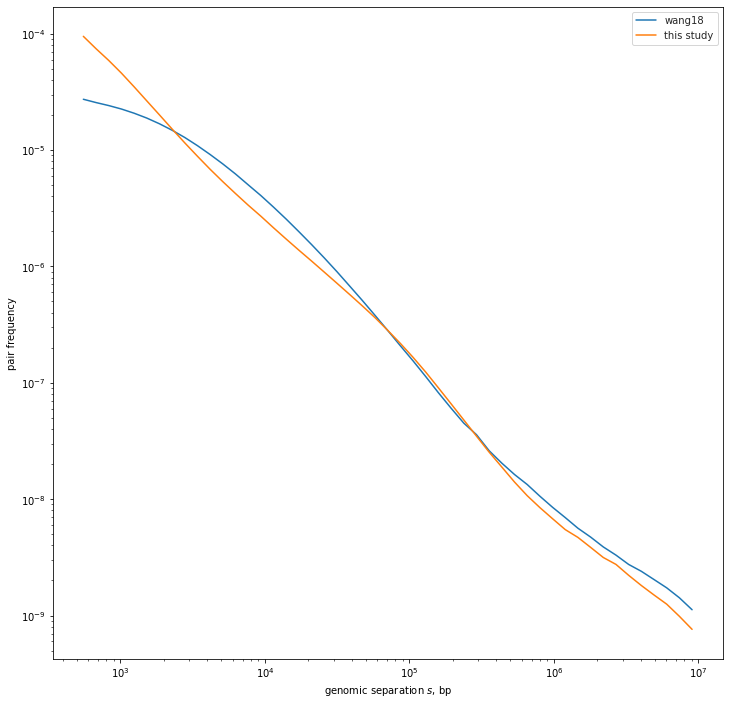

In [123]:
fig, ax = plt.subplots(figsize = (12,12))
sns.set_style('ticks')
ax.loglog(Total_ps_data1["dmean"], Total_ps_data1["scaling_norm"], label="wang18")
ax.loglog(Total_ps_data2["dmean"], Total_ps_data2["scaling_norm"], label="this study")

plt.xlabel(r'genomic separation $s$, bp')
plt.ylabel('pair frequency')
plt.legend()
plt.savefig("ps_curve.pdf")